# Monod rate of equation parameter estimation

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')
DATA_FILEPATH = '../data/'
DATA_FILENAME = 'experimental_data.csv'

## 1. Load Data

In [2]:
data = pd.read_csv(os.path.join(DATA_FILEPATH, DATA_FILENAME))
data.head()

,rg,cell_conc,substract_conc
0,0.327771,0.999988,249.918627
1,0.345758,1.054941,249.420005
2,0.364695,1.112728,248.925243
3,0.384627,1.173515,247.159035
4,0.404835,1.235190,246.851701


## 2. Feature Creation - Linearization of Monod Equation

<br>

$$r_g = \frac{\mu_{max} C_S C_C}{K_S + C_S}$$

$$\frac{1}{r_g} = \frac{K_S + C_S}{\mu_{max} C_S C_C}$$

$$\frac{1}{r_g} = \frac{K_S}{\mu_{max} C_S C_C} + \frac{C_S}{\mu_{max} C_S C_C}$$

$$\frac{C_C}{r_g} = \frac{K_S}{\mu_{max} C_S} + \frac{1}{\mu_{max}}$$

In [3]:
# linearization of Monod's equation
data['cc_rg'] = data['cell_conc'] / data['rg']
data['1_cs'] = 1 / (data['substract_conc'])

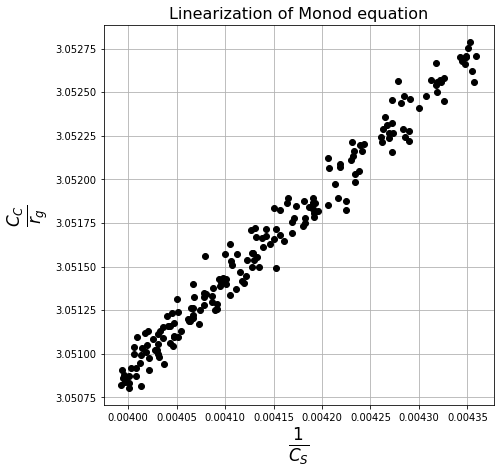

In [4]:
# visualization of linearized Monod equation
fig = plt.figure(figsize =(7,7))

ax1 = fig.add_subplot(1,1,1)
ax1.plot(data['1_cs'], data['cc_rg'], 'ko')
ax1.set_xlabel(r'$\frac{1}{C_S}$', size = 24)
ax1.set_ylabel(r'$\frac{C_C}{r_g}$', size = 24)
ax1.set_title('Linearization of Monod equation', size = 16)
ax1.grid()

## 3. Modeling - Estimation of Parameters

<br>

### 3.1. K Fold Cross Validation

In [5]:
# predictors and predicted projection
x = data[['1_cs']]
y = data[['cc_rg']]

In [6]:
# class instance
kfold = KFold(n_splits = 30)

In [7]:
# kfold cross training and validation
r2 = []
Ks_list = []
umax_list = []

for train_index, test_index in kfold.split(x):
    
    # sample train and tests sets
    x_train, x_test = x.loc[train_index, :], x.loc[test_index, :]
    y_train, y_test = y.loc[train_index, :], y.loc[test_index, :]
    
    # create model object and train in train set
    model = LinearRegression()
    model = model.fit(x_train, y_train)
    
    # make predictions in the test set and store in the r2 list
    yhat = model.predict(x_test)
    r2.append(r2_score(y_test, yhat))
    
    # calculate the reaction paremeters and append them to the respective lists
    umax = 1/model.intercept_[0]
    umax_list.append(umax)
    Ks_list.append(umax*model.coef_[0][0])

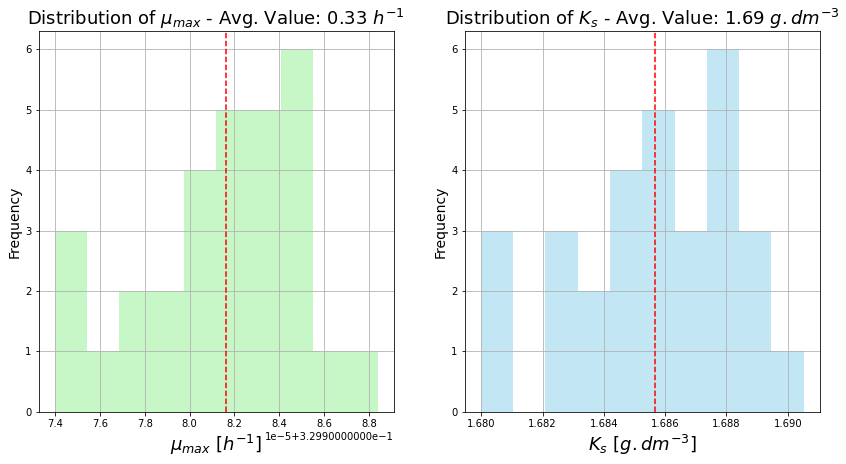

In [8]:
# compute mean and standard deviation
umax_avg = np.mean(umax_list)
Ks_avg = np.mean(Ks_list)

# visualization of results
fig = plt.figure(figsize = (14,7))

# histogram of umax
ax1 = fig.add_subplot(1,2,1)
ax1.hist(umax_list, facecolor = 'lightgreen', alpha = 0.5)
ax1.set_xlabel(r'$\mu_{max}$ $[h^{-1}]$', size = 18)
ax1.set_ylabel('Frequency', size = 14)
ax1.set_title(r'Distribution of $\mu_{max}$ - Avg. Value: %.2f $h^{-1}$'%(umax_avg), size = 18)
ax1.axvline(x = umax_avg, ls = '--', color = 'red')
ax1.grid()

# histogram of Ks
ax2 = fig.add_subplot(1,2,2)
ax2.hist(Ks_list, facecolor = 'skyblue', alpha = 0.5)
ax2.set_xlabel(r'$K_{s}$ $[g.dm^{-3}]$', size = 18)
ax2.set_ylabel('Frequency', size = 14)
ax2.set_title(r'Distribution of $K_{s}$ - Avg. Value: %.2f $g.dm^{-3}$'%(Ks_avg), size = 18)
ax2.axvline(x = Ks_avg, ls = '--', color = 'red')
ax2.grid()